In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os

plt.style.use('/home/llr/ilc/shi/code/Plot_style/cepc.mplstyle')
figSize = (8, 6)

# Read Data
#Config = ("SumE", "NHits","RecoE_cheat","RecoE_LW")
#Config = ("SumE", "NHits","RecoE_MLP")
#Config = ("SumE", "RecoE_MLP_GELU","RecoE_MLP_Softsign","RecoE_MLP_Res_PReLU")
Config = ("SumE","NHits","RecoE_MLP_LR1e-03")
#Config = ("SumE", "NHits")
colors = ['blue', 'green', 'red','orange','purple']
dataPath = "/home/llr/ilc/shi/data/SiWECAL-Prototype/Simu2025-06/CONF0/gamma/Validate/Merged_X5.0mm_Y5.0mm_Si0.45mm_layer30_in60"

particleEnergy = []
meanGamma = []
meanGammaErr = []
peakGamma = []
peakGammaErr = []
resGamma = []
resGammaErr = []

for i_config in range(len(Config)):
    fileName = os.path.join(dataPath, f"{Config[i_config]}_Fit.csv")
    df = pd.read_csv(fileName)

    particleEnergy.append(df["ParticleEnergy"].to_numpy())
    meanGamma.append(df["Mean_Gamma"].to_numpy())
    meanGammaErr.append(df["Mean_Gamma_Error"].to_numpy())
    peakGamma.append(df["Peak_Gamma"].to_numpy())
    peakGammaErr.append(df["Peak_Gamma_Error"].to_numpy())
    resGamma.append(df["Res_Gamma"].to_numpy())
    resGammaErr.append(df["Res_Gamma_Error"].to_numpy())



Config: SumE
Fit Coefficients: [1.         0.01881109]
Config: NHits
Fit Coefficients: [1.         4.81931211]
Config: RecoE_MLP_LR1e-03
Fit Coefficients: [1.         0.04400731]


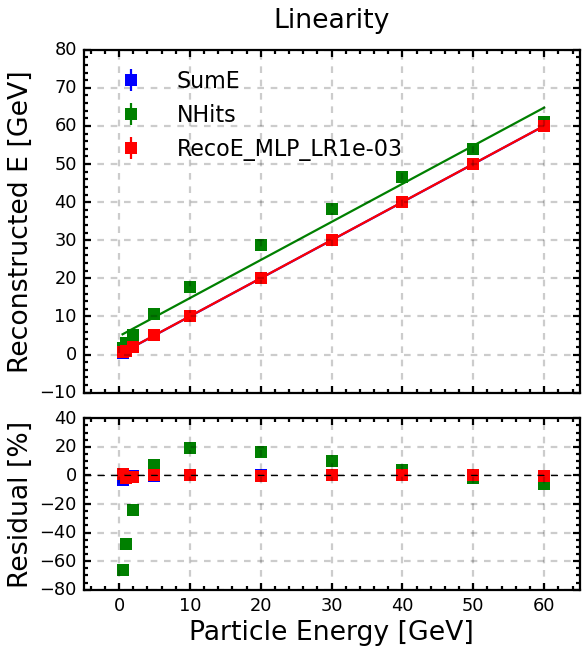

Config: SumE
Config: NHits
Config: RecoE_MLP_LR1e-03


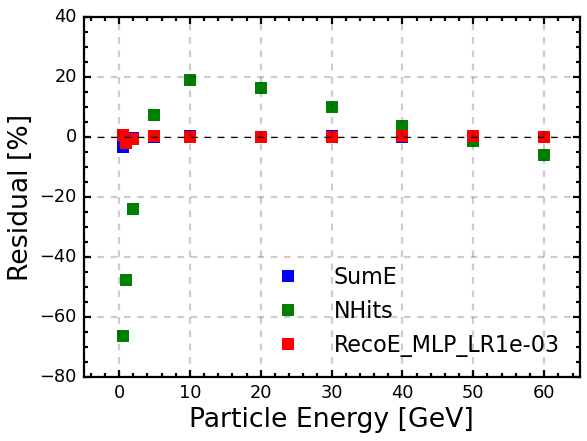

In [ ]:

# Linearity and Resolution
def linear_func(x, a, b):
    return a * x + b

def fitAndResidualRatio(x, y):
    """Linear fit and return coefficients, fit values, and relative residuals."""
    a0 = (y[-1] - y[0]) / (x[-1] - x[0])
    b0 = y[0]
    p0 = [a0, b0]
    upper_bound = [5*a0, np.inf]
    lower_bound = [0, -np.inf]  # Ensure slope is non-negative
    coeffs, cov = curve_fit(linear_func, x, y, p0=p0, bounds=(lower_bound, upper_bound))
    fitVals = linear_func(x, *coeffs)
    residualRatio = (y - fitVals) / fitVals
    return coeffs, fitVals, residualRatio
fitGamma,ResGamma = [],[]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(figSize[0], figSize[1]*1.5), 
        sharex=True,gridspec_kw={'height_ratios':[1, 0.5],'hspace': 0.1})
MarkerSize = 10

for i_c in range(len(Config)):
    print(f"Config: {Config[i_c]}")
    #Calib
    coeff,fitVals,residualRatio = fitAndResidualRatio(particleEnergy[i_c], meanGamma[i_c])
    meanGamma[i_c] = (meanGamma[i_c])/(coeff[0])
    meanGammaErr[i_c] = meanGammaErr[i_c]/(coeff[0])
    coeff,fitVals,residualRatio = fitAndResidualRatio(particleEnergy[i_c], meanGamma[i_c])
    #residualRatio = (meanGamma[i_c] - particleEnergy[i_c]) / particleEnergy[i_c]
    fitGamma.append(fitVals)
    ResGamma.append(residualRatio)
    print(f"Fit Coefficients: {coeff}")
    # Gamma
    ax1.errorbar(particleEnergy[i_c], meanGamma[i_c], yerr=meanGammaErr[i_c],
        fmt='s', capsize=4, label=Config[i_c], color=colors[i_c], markersize=MarkerSize
    )
    ax1.plot(particleEnergy[i_c], fitGamma[i_c], '-', color=colors[i_c])
    ax1.set_ylabel("Reconstructed E [GeV]")
    #ax1.set_ylim(-100, 1300)
    ax1.set_xlim(-5, 65)
    ax1.set_title("Linearity")
    ax1.legend(loc='upper left')
    ax1.grid(True, linestyle='--', alpha=0.2)

    ax2.plot(particleEnergy[i_c], ResGamma[i_c]*100, 's', label='Gamma', color=colors[i_c],markersize=MarkerSize)

    ax2.axhline(0, color='black', lw=1, linestyle='--')
    ax2.set_xlabel("Particle Energy [GeV]")
    ax2.set_ylabel("Residual [%]")
    ax2.grid(True, linestyle='--', alpha=0.2)
plt.show()

plt.figure(figsize=figSize)

for i_c in range(len(Config)):
    print(f"Config: {Config[i_c]}")
    # 假设 fitGamma 和 ResGamma 已经计算好
    plt.plot(particleEnergy[i_c], ResGamma[i_c]*100, 's', label=Config[i_c], 
             color=colors[i_c], markersize=MarkerSize)

plt.axhline(0, color='black', lw=1, linestyle='--')
plt.xlabel("Particle Energy [GeV]")
plt.ylabel("Residual [%]")
plt.xlim(-5, 65)
plt.ylim(-5, 5)
plt.grid(True, linestyle='--', alpha=0.2)
plt.legend(loc='lower right')
plt.show()


Config: SumE
Config: NHits
Config: RecoE_MLP_LR1e-03


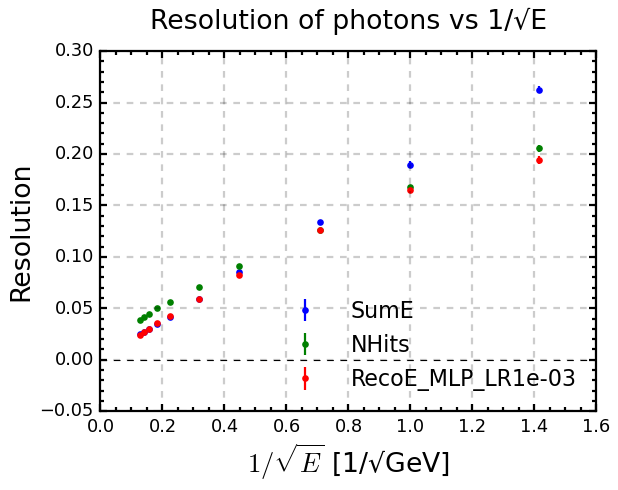

In [22]:
plt.figure(figsize=figSize)
for i_c in range(len(Config)):
    print(f"Config: {Config[i_c]}")
    # 横坐标改为 1/sqrt(E)
    x_vals = 1 / np.sqrt(particleEnergy[i_c])
    
    plt.errorbar(x_vals, resGamma[i_c], yerr=resGammaErr[i_c],
                 fmt='o', capsize=4, label=Config[i_c], color=colors[i_c])

plt.axhline(0, color='black', linestyle='--', lw=1)
plt.xlabel(r"$1/\sqrt{E}$ [1/√GeV]")
plt.ylabel("Resolution")
plt.title("Resolution of photons vs 1/√E")
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.2)
plt.show()


    